In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import os
import numpy as np
from copy import deepcopy
import py3Dmol
from ipywidgets import interact, IntSlider
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)

import plotly as pl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import seaborn as sns
sns.set(style="whitegrid")

import ast
import math
import random as random
import copy
np.random.seed(7678)
from sklearn.metrics import auc, roc_curve

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

pl.offline.init_notebook_mode(connected=True)


from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import sys
sys.path.insert(0, '../MutCat/')
#import ccal # Original repository is in https://github.com/UCSD-CCAL/ccal
#from ancillary_v1_0 import *

In [3]:
CCLE_pathways = pd.read_table('/home/ebc/variome/CT2/ccal_PT/Inference/data/CCLE_19Q3/CCLE_expression.PATHWAYS.c2_c5_h.gct',sep='\t', skiprows=2,index_col=0).drop('Description',1)

sig = CCLE_pathways.loc['SINGH_NFE2L2_TARGETS',:].sort_values(ascending = False)
sig_mean = sig.mean()
sig_std = sig.std()

sig_Act = pd.Series(np.where(sig >= sig_mean + sig_std, 1, 0), 
                     index = sig.index, name='Active_sample')

sig_Null = pd.Series(np.where(sig < sig_mean - sig_std, 1, 0), 
                     index = sig.index, name='Unactive_sample')

del CCLE_pathways

In [5]:
DF_CCLE = pd.read_csv('/media/ebc/F47A-25A8/PDBMap_Backup/CCLE/XYZ/GW_Full_Gene_XYZ.csv',index_col=0)

In [6]:
DF_prob_map = pd.read_csv('~/variome/GIT/MutCat/analysis/NRF2/dataframes/GW/DF_Prob_cluster_size_gt_2_MAP_TO_TUMORBARCODE.csv',index_col=0)
DF_Prob_All_dist = pd.read_csv('~/variome/GIT/MutCat/analysis/NRF2/dataframes/GW/DF_Prob_cluster_size_gt_2_MAP_TO_CLUSTERING.csv',index_col=0)

In [7]:
ROC_thres = 0.5
sig_thres = sig.mean()+sig.std()
ii = 0

In [8]:
df_sig = pd.DataFrame(sig)
df_sig = df_sig.reset_index()
df_sig.rename(columns={'index':'Tumor_Sample_Barcode'},inplace=True)


sig_thres_act = sig.mean()+sig.std()
sig_thres_unact = sig.mean()-sig.std()

In [9]:
# only predict variants where we have signature data for
for_test_train = DF_prob_map[DF_prob_map.Tumor_Sample_Barcode.isin(sig_Act.index)][['Hugo_Symbol','Tumor_Sample_Barcode','var_id']].drop_duplicates()

print("Num Genes: %s, Num variants: %s"%(len(for_test_train.Hugo_Symbol.unique()),len(for_test_train.var_id.unique())))

Num Genes: 4877, Num variants: 93464


In [10]:
test_train_split = 0.8

# get test/train data
msk = np.random.rand(len(df_sig)) < test_train_split
train = df_sig[msk]
test = df_sig[~msk]


In [11]:
print(len(train),len(test))

923 287


In [12]:
train = for_test_train[for_test_train.Tumor_Sample_Barcode.isin(train.Tumor_Sample_Barcode)]
test = for_test_train[for_test_train.Tumor_Sample_Barcode.isin(test.Tumor_Sample_Barcode)]

print("Num Genes in train: %s, Num variants in train: %s"%(len(train.Hugo_Symbol.unique()),len(train.var_id.unique())))
print("Num tumor samples in train: %s"%(len(train.Tumor_Sample_Barcode.unique())))
print()
      
print("Num Genes in test: %s, Num variants in test: %s"%(len(test.Hugo_Symbol.unique()),len(test.var_id.unique())))
print("Num tumor samples in test: %s"%(len(test.Tumor_Sample_Barcode.unique())))

Num Genes in train: 4876, Num variants in train: 77302
Num tumor samples in train: 850

Num Genes in test: 4405, Num variants in test: 18229
Num tumor samples in test: 259


In [13]:
test = test.sort_values('Tumor_Sample_Barcode',ascending=True)
train = train.sort_values('Tumor_Sample_Barcode',ascending=True)

In [15]:
def get_cond_probability_from_subset(c,sig_Act):

    N = len(sig_Act)-1

    prob_c = pd.Series(c['act'].value_counts()/N, name = 'prob_c')
    prob_Act = pd.Series(sig_Act.value_counts()/N, name = 'prob_Act')
    joint_counts_Act_vs_c = pd.crosstab(sig_Act, c['act'])
    joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
    cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')


    cond_prob_sum = np.mean(cond_prob_Act_given_c.sum(axis=0).values)

    try:
        cond_prob_1_1 = np.round(cond_prob_Act_given_c, decimals=3).values[1][1]
        cond_prob_1_0 = np.round(cond_prob_Act_given_c, decimals=3).values[1][0]
        cond_prob_0_0 = np.round(cond_prob_Act_given_c, decimals=3).values[0][0]
        cond_prob_0_1 = np.round(cond_prob_Act_given_c, decimals=3).values[0][1]
        
    except IndexError:
        pass

    return(cond_prob_1_1)

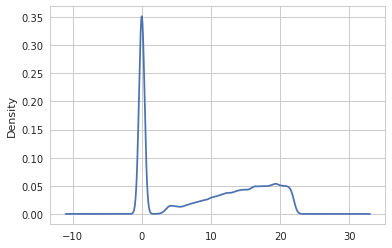

In [17]:
DF_prob_map[(DF_prob_map.dist<22)].dist.plot(kind='KDE')

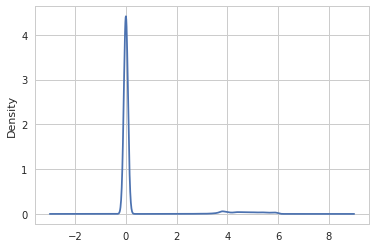

In [43]:
DF_prob_map[(DF_prob_map.dist<6)].dist.plot(kind='KDE')

In [29]:
dist_binned = pd.Series(np.round(DF_prob_map[(DF_prob_map.dist<22)].dist.values,decimals=0))

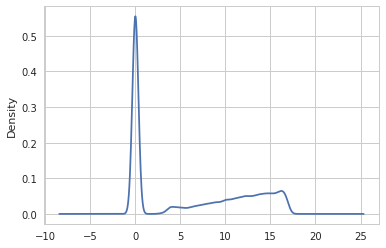

In [38]:
dist_binned[dist_binned<17].plot(kind='KDE')

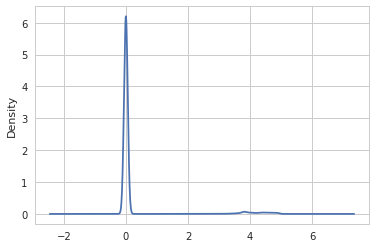

In [42]:
dist_binned[dist_binned<5].plot(kind='KDE')

In [44]:
dist_binned[dist_binned<10].value_counts()/len(dist_binned[dist_binned<17])*100  

0.0    46.966231
3.8     0.419694
9.9     0.407043
9.8     0.369649
9.0     0.364994
8.9     0.362408
9.7     0.340927
9.6     0.338062
8.7     0.337426
9.4     0.333527
9.1     0.320479
9.2     0.320121
8.4     0.317296
8.8     0.315944
9.5     0.313477
8.5     0.309579
8.6     0.306396
7.9     0.306078
7.8     0.305243
7.7     0.297843
7.6     0.293547
9.3     0.289489
8.1     0.284795
8.2     0.276878
7.0     0.261046
8.0     0.258937
6.9     0.252493
8.3     0.248355
7.4     0.247599
6.4     0.240757
         ...    
4.7     0.175516
4.9     0.174640
6.0     0.168872
5.8     0.168753
6.1     0.164337
3.7     0.161632
5.2     0.156778
5.5     0.149777
5.7     0.144566
5.6     0.134740
4.2     0.134700
3.6     0.111746
3.5     0.064764
3.4     0.056609
3.3     0.036360
2.9     0.031427
3.2     0.023909
2.8     0.022278
3.0     0.022198
3.1     0.021800
2.7     0.013526
2.6     0.005569
1.6     0.000557
2.0     0.000438
2.4     0.000358
0.4     0.000278
1.1     0.000199
1.7     0.0001

In [98]:
ind = DF_prob_map[(DF_prob_map.Tumor_Sample_Barcode=='NCIH2172_LUNG')&(DF_prob_map.var_id.isin(test.var_id))&(DF_prob_map.dist<17)].sort_values(['Hugo_Symbol','P(Act=1|c=1)'],ascending=False)[['Hugo_Symbol','var_id']].drop_duplicates().index.tolist()

BF = DF_prob_map[DF_prob_map.index.isin(ind)]

BF = BF[BF.Num_samples>=np.percentile(BF.Num_samples.value_counts(),55)]

In [99]:
len(BF.sort_values(['Num_samples','P(Act=1|c=1)'],ascending=False))

10

In [100]:
from itertools import combinations
def ord_comb(l,n):
    return list(combinations(l,n))

#### TESTING ####
a = BF.ID.tolist()
itemsets = ord_comb(a,3)

len(itemsets)

120

In [101]:
BF.sort_values(['Num_samples','P(Act=1|c=1)'],ascending=False)

,Hugo_Symbol,ID,Num_samples,Num_act_in_sample_set,Num_unact_in_sample_set,dist,P(Act=1|c=1),P(Act=1|c=0),Risk_Ratio,Log_Odds_Ratio,Log_CI_OR,Protein_Change,var_id,structureChainId,group_number,Tumor_Sample_Barcode
1600742,FBXW7,FBXW7_2OVQ.B_c_93_,44,7,37,16.646664,0.159091,0.143225,1.110778,0.176834,-0.222024,p.R505S,chr4:g.153247289G>T,2OVQ.B,2505,NCIH2172_LUNG
522115,BIRC3,BIRC3_3M0D.D_c_26_,15,3,12,14.209687,0.200000,0.143096,1.397661,0.514411,0.179214,p.Y57Y,chr11:g.102195411C>T,3M0D.D,57,NCIH2172_LUNG
522073,BIRC3,BIRC3_3M0D.D_c_23_,12,3,9,5.942591,0.250000,0.142738,1.751462,0.791772,0.212018,p.F55F,chr11:g.102195405C>T,3M0D.D,55,NCIH2172_LUNG
5706274,XDH,XDH_2E1Q.D_c_120_,12,3,9,15.978239,0.250000,0.142738,1.751462,0.791772,0.212018,p.A317S,chr2:g.31605956C>A,2E1Q.D,317,NCIH2172_LUNG
3613149,PSMA4,PSMA4_5LF7.B_c_15_,8,4,4,10.567471,0.500000,0.141431,3.535294,1.801003,0.275109,p.D140H,chr15:g.78838017G>C,5LF7.B,114,NCIH2172_LUNG
5719509,XYLT1,XYLT1_6EJB.A_c_86_,8,3,5,14.275373,0.375000,0.142263,2.635965,1.342201,0.300021,p.R754L,chr16:g.17211799C>A,6EJB.A,754,NCIH2172_LUNG
996737,COL3A1,COL3A1_6FZV.A_c_18_,8,2,6,15.001595,0.250000,0.143095,1.747093,0.831891,0.383583,p.C1464R,chr2:g.189876489T>C,6FZV.A,243,NCIH2172_LUNG
2232918,ITK,ITK_4HCV.A_c_29_,8,2,6,16.791769,0.250000,0.143095,1.747093,0.831891,0.383583,p.L379M,chr5:g.156670707C>A,4HCV.A,379,NCIH2172_LUNG
2824473,MMP16,MMP16_1RM8.A_c_21_,8,2,6,14.393899,0.250000,0.143095,1.747093,0.831891,0.383583,p.P292T,chr8:g.89128945G>T,1RM8.A,292,NCIH2172_LUNG
2968480,NLGN4X,NLGN4X_2WQZ.B_c_53_,8,2,6,15.902517,0.250000,0.143095,1.747093,0.831891,0.383583,p.V198V,chrX:g.5947352C>A,2WQZ.B,198,NCIH2172_LUNG


In [ ]:
ind = DF_prob_map[(DF_prob_map.Tumor_Sample_Barcode=='NCIH2172_LUNG')&(DF_prob_map.var_id.isin(test.var_id))&(DF_prob_map.dist<17)&(DF_prob_map.Num_samples>7)].sort_values(['Hugo_Symbol','P(Act=1|c=1)'],ascending=False)[['Hugo_Symbol','var_id']].drop_duplicates().index.tolist()

TF = DF_prob_map[DF_prob_map.index.isin(ind)]

In [107]:
N = len(sig_Act)-1

prob_c = pd.Series(c['act'].value_counts()/N, name = 'prob_c')
prob_Act = pd.Series(sig_Act.value_counts()/N, name = 'prob_Act')
joint_counts_Act_vs_c = pd.crosstab(sig_Act, c['act'])
joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')


cond_prob_sum = np.mean(cond_prob_Act_given_c.sum(axis=0).values)

try:
    cond_prob_1_1 = np.round(cond_prob_Act_given_c, decimals=3).values[1][1]
    cond_prob_1_0 = np.round(cond_prob_Act_given_c, decimals=3).values[1][0]
    cond_prob_0_0 = np.round(cond_prob_Act_given_c, decimals=3).values[0][0]
    cond_prob_0_1 = np.round(cond_prob_Act_given_c, decimals=3).values[0][1]

except IndexError:
    pass

np.round(joint_prob_Act_vs_c, decimals=3).values[1][1]
prob_c.values[1]

0.015715467328370553

In [131]:
sig['NCIH2172_LUNG']

6959.500302459351

In [175]:
tt = DF_prob_map.sort_values('P(Act=1|c=1)',ascending=True)
tt.head(10)

,Hugo_Symbol,ID,Num_samples,Num_act_in_sample_set,Num_unact_in_sample_set,dist,P(Act=1|c=1),P(Act=1|c=0),Risk_Ratio,Log_Odds_Ratio,Log_CI_OR,Protein_Change,var_id,structureChainId,group_number,Tumor_Sample_Barcode
0,A1CF,A1CF_2CPD.A_c_10_,3,0,3,6.229596,0.0,0.144159,0.0,-0.167129,1.087747,p.V290V,chr10:g.52576037C>A,2CPD.A,290,RDES_BONE
860045,CDK6,CDK6_2EUF.B_c_10_,4,0,4,10.501115,0.0,0.144279,0.0,-0.419411,1.073703,p.L176L,chr7:g.92354949T>A,2EUF.B,176,DMS79_LUNG
860046,CDK6,CDK6_2EUF.B_c_10_,4,0,4,10.501115,0.0,0.144279,0.0,-0.419411,1.073703,p.R144H,chr7:g.92355046C>T,2EUF.B,144,LS180_LARGE_INTESTINE
860047,CDK6,CDK6_2EUF.B_c_10_,4,0,4,10.501115,0.0,0.144279,0.0,-0.419411,1.073703,p.V190I,chr7:g.92300819C>T,2EUF.B,190,ECC10_STOMACH
860048,CDK6,CDK6_2EUF.B_c_10_,4,0,4,10.501115,0.0,0.144279,0.0,-0.419411,1.073703,p.R168H,chr7:g.92354974C>T,2EUF.B,168,FTC133_THYROID
860049,CDK6,CDK6_2EUF.B_c_11_,5,0,5,11.487401,0.0,0.144398,0.0,-0.621051,1.064557,p.P199S,chr7:g.92300792G>A,2EUF.B,199,MM426_SKIN
860050,CDK6,CDK6_2EUF.B_c_11_,5,0,5,11.487401,0.0,0.144398,0.0,-0.621051,1.064557,p.L176L,chr7:g.92354949T>A,2EUF.B,176,DMS79_LUNG
860051,CDK6,CDK6_2EUF.B_c_11_,5,0,5,11.487401,0.0,0.144398,0.0,-0.621051,1.064557,p.A197S,chr7:g.92300798C>A,2EUF.B,197,HEC59_ENDOMETRIUM
860052,CDK6,CDK6_2EUF.B_c_11_,5,0,5,11.487401,0.0,0.144398,0.0,-0.621051,1.064557,p.R144H,chr7:g.92355046C>T,2EUF.B,144,LS180_LARGE_INTESTINE
860053,CDK6,CDK6_2EUF.B_c_11_,5,0,5,11.487401,0.0,0.144398,0.0,-0.621051,1.064557,p.V190I,chr7:g.92300819C>T,2EUF.B,190,ECC10_STOMACH


In [135]:
ind = DF_prob_map[(DF_prob_map.Tumor_Sample_Barcode=='NCIH2172_LUNG')&(DF_prob_map.var_id.isin(test.var_id))&(DF_prob_map.dist<17)].sort_values(['Hugo_Symbol','P(Act=1|c=1)'],ascending=False)[['Hugo_Symbol','var_id']].drop_duplicates().index.tolist()
BF = DF_prob_map[DF_prob_map.index.isin(ind)]
BF

,Hugo_Symbol,ID,Num_samples,Num_act_in_sample_set,Num_unact_in_sample_set,dist,P(Act=1|c=1),P(Act=1|c=0),Risk_Ratio,Log_Odds_Ratio,Log_CI_OR,Protein_Change,var_id,structureChainId,group_number,Tumor_Sample_Barcode
11709,ABCB10,ABCB10_3ZDQ.A_c_21_,4,1,3,14.473321,0.250000,0.143449,1.742775,0.937231,0.652071,p.Q258R,chr1:g.229683394T>C,3ZDQ.A,258,NCIH2172_LUNG
96172,ACSM2A,ACSM2A_3EQ6.B_c_55_,5,2,3,11.312413,0.400000,0.142739,2.802326,1.453837,0.489206,p.P114L,chr16:g.20477002C>T,3EQ6.B,114,NCIH2172_LUNG
112664,ACTN2,ACTN2_4D1E.A_c_96_,5,2,3,12.260509,0.400000,0.142739,2.802326,1.453837,0.489206,p.Q460H,chr1:g.236908050G>T,4D1E.A,460,NCIH2172_LUNG
121091,ACVR2B,ACVR2B_2QLU.A_c_13_,4,1,3,11.263581,0.250000,0.143449,1.742775,0.937231,0.652071,p.M411L,chr3:g.38523938A>C,2QLU.A,411,NCIH2172_LUNG
233357,ALDOA,ALDOA_4ALD.A_c_29_,7,3,4,13.254195,0.428571,0.142145,3.015038,1.543841,0.340894,p.Q275H,chr16:g.30081176G>C,4ALD.A,246,NCIH2172_LUNG
322325,AP2B1,AP2B1_2VGL.B_c_21_,3,3,0,10.968282,1.000000,0.141674,7.058480,3.744932,1.087768,p.T401N,chr17:g.33963406C>A,2VGL.B,401,NCIH2172_LUNG
402707,ARIH1,ARIH1_5UDH.B_c_38_,7,2,5,11.587683,0.285714,0.142976,1.998339,0.999915,0.407927,p.R132K,chr15:g.72810427G>A,5UDH.B,132,NCIH2172_LUNG
476662,BCHE,BCHE_3O9M.B_c_43_,5,3,2,13.038729,0.600000,0.141909,4.228070,2.133562,0.489230,p.R493I,chr3:g.165547344C>A,3O9M.B,465,NCIH2172_LUNG
522073,BIRC3,BIRC3_3M0D.D_c_23_,12,3,9,5.942591,0.250000,0.142738,1.751462,0.791772,0.212018,p.F55F,chr11:g.102195405C>T,3M0D.D,55,NCIH2172_LUNG
522115,BIRC3,BIRC3_3M0D.D_c_26_,15,3,12,14.209687,0.200000,0.143096,1.397661,0.514411,0.179214,p.Y57Y,chr11:g.102195411C>T,3M0D.D,57,NCIH2172_LUNG


In [137]:
sample = 'NCIH2172_LUNG'

DF_ind = pd.DataFrame()

cls = BF.ID.tolist()

NB = 0

for item in cls:
    
    clear_output(wait=True)
    print(cls.index(item),"out of",len(cls))
    
    c = pd.DataFrame(sig)
    c.rename(columns={'SINGH_NFE2L2_TARGETS':'act'},inplace=True)
    c['act'] = [0 for i in c.index]
    
    tt = DF_prob_map[(DF_prob_map.var_id.isin(train.var_id))&(DF_prob_map.ID==item)&(DF_prob_map.Tumor_Sample_Barcode!=sample)].Tumor_Sample_Barcode.tolist()
    c.loc[((c.index.isin(tt))),'act'] = 1
    
    LOR = get_naive_bayes_probability(c,sig_Act)
    
    NB = NB + np.round(LOR, decimals=3)
        
    DF_ind = pd.concat([DF_ind, pd.DataFrame([{'itemset':item,'LOR':LOR}])])

NB

113 out of 114


nan

In [148]:
np.sum(pd.notnull(DF_ind.LOR.values))

58

In [147]:
DF_ind.replace([np.inf, -np.inf], np.nan, inplace=True)

DF_ind.dropna(subset=["LOR"], how="all", inplace=True)

DF_ind

,LOR,itemset
0,0.685455,ACSM2A_3EQ6.B_c_55_
0,0.685455,ALDOA_4ALD.A_c_29_
0,0.177027,ARIH1_5UDH.B_c_38_
0,1.784067,BCHE_3O9M.B_c_43_
0,0.281211,BIRC3_3M0D.D_c_23_
0,-0.006526,BIRC3_3M0D.D_c_26_
0,0.685455,CD22_5VKJ.A_c_24_
0,2.478715,CHCHD5_2LQL.A_c_2_
0,-0.006526,COL3A1_6FZV.A_c_18_
0,1.089420,EGFR_5X2A.B_c_29_


In [125]:
def get_naive_bayes_probability(c,sig_Act):

    N = len(sig_Act)-1

    prob_c = pd.Series(c['act'].value_counts()/N, name = 'prob_c')
    prob_Act = pd.Series(sig_Act.value_counts()/N, name = 'prob_Act')
    joint_counts_Act_vs_c = pd.crosstab(sig_Act, c['act'])
    joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
    cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')

    cond_prob_sum = np.mean(cond_prob_Act_given_c.sum(axis=0).values)

    try:
        cond_prob_1_1 = np.round(cond_prob_Act_given_c, decimals=3).values[1][1]
        #cond_prob_1_0 = np.round(cond_prob_Act_given_c, decimals=3).values[1][0]
        #cond_prob_0_0 = np.round(cond_prob_Act_given_c, decimals=3).values[0][0]
        cond_prob_0_1 = np.round(cond_prob_Act_given_c, decimals=3).values[0][1]
        
    except IndexError:
        cond_prob_1_1 = np.nan
        cond_prob_0_1 = np.nan
        LOR = np.nan
        
    if pd.notnull(cond_prob_1_1) & pd.notnull(cond_prob_0_1):
        nom = np.true_divide(cond_prob_1_1,cond_prob_0_1)
        denom = np.true_divide(prob_Act.values[1],prob_Act[0])
        
        LOR = np.log(np.true_divide(nom,denom))
        

    return(LOR)

In [156]:
active_set = sig_Act[sig_Act>0]
not_active_set = sig_Act[sig_Act==0]



In [161]:
test_train_split = 0.2

# get test/train data
msk_active = np.random.rand(len(active_set)) < test_train_split
msk_unactive = np.random.rand(len(not_active_set)) < test_train_split

test = pd.concat([active_set[msk_active],not_active_set[msk_unactive]])

train = pd.concat([active_set[~msk_active],not_active_set[~msk_unactive]])

print(len(test),len(train))

244 966


In [171]:

DF_test_set = pd.DataFrame()

for sample in test.index[100:110]:

    DF_ind = pd.DataFrame()
    
    ind = DF_prob_map[(DF_prob_map.Tumor_Sample_Barcode==sample)&(DF_prob_map.dist<17)].sort_values(['Hugo_Symbol','P(Act=1|c=1)'],ascending=False)[['Hugo_Symbol','var_id']].drop_duplicates().index.tolist()
    BF = DF_prob_map[DF_prob_map.index.isin(ind)]

    cls = BF.ID.tolist()

    NB = 0

    for item in cls:

        clear_output(wait=True)
        print(cls.index(item),"out of",len(cls))

        c = pd.DataFrame(sig)
        c.rename(columns={'SINGH_NFE2L2_TARGETS':'act'},inplace=True)
        c['act'] = [0 for i in c.index]

        tt = DF_prob_map[(DF_prob_map.ID==item)&(DF_prob_map.Tumor_Sample_Barcode!=sample)].Tumor_Sample_Barcode.tolist()
        c.loc[((c.index.isin(tt))),'act'] = 1

        LOR = get_naive_bayes_probability(c,sig_Act)

        DF_ind = pd.concat([DF_ind, pd.DataFrame([{'itemset':item,'LOR':LOR}])])


    DF_ind.replace([np.inf, -np.inf], np.nan, inplace=True)

    DF_ind.dropna(subset=["LOR"], how="all", inplace=True)

    F = np.sum(pd.notnull(DF_ind.LOR.values))
    
    DF_test_set = pd.concat([DF_test_set,pd.DataFrame([{'Tumor_Sample_Barcode':sample,'F(c|Xi)':F,'GSEA':sig[sample],'active':sig_Act[sample]}])])



13 out of 14


KeyError: ['LOR']

In [170]:
DF_test_set

,F(c|Xi),GSEA,Tumor_Sample_Barcode,active
0,7,8317.610679,RERFLCMS_LUNG,1
0,22,8280.073630,HUH1_LIVER,1
0,11,7656.263763,SNU475_LIVER,1
0,19,7487.151863,NCIH1437_LUNG,1
0,4,7033.799084,LI7_LIVER,1
0,12,6939.221851,RMUGS_OVARY,1
0,46,6818.348401,PLCPRF5_LIVER,1
0,11,6744.539395,NCIH28_PLEURA,1
0,11,6474.515002,SKRC20_KIDNEY,1
0,24,6042.205778,TT_OESOPHAGUS,1


In [172]:
DF_test_set

,F(c|Xi),GSEA,Tumor_Sample_Barcode,active
0,23,3431.935360,KYO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0
0,13,3428.628065,BXPC3_PANCREAS,0
0,10,3426.297353,TE125T_FIBROBLAST,0
0,17,3415.990071,GCIY_STOMACH,0
0,8,3413.494799,HS766T_PANCREAS,0
0,24,3410.258995,MM1S_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0
0,67,3397.599036,FTC238_THYROID,0
0,6,3395.816119,HS870T_FIBROBLAST,0
